In [1]:
#imports
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsforecast import StatsForecast
from statsforecast.models import Naive, SeasonalNaive, SeasonalWindowAverage, AutoARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import numpy as np
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

In [31]:
dataset_path = '../preco_petroleo.csv'
df = pd.read_csv(dataset_path, sep=';', engine='python')
df = df.iloc[:, :-1]

# Convert 'Data' column to datetime format for proper time series handling
df['Data'] = pd.to_datetime(df['Data'], format='%d.%m.%Y')

# Set 'Data' column as index to facilitate time series operations
df.set_index('Data', inplace=True)

# Display dataframe information
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6924 entries, 2004-01-02 to 2024-12-31
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Preco   6924 non-null   float64
dtypes: float64(1)
memory usage: 108.2 KB


The decision to focus on the data from **2021 onwards** is based on several key factors related to market behavior and data quality:

1. **Structural Market Changes**:  
   The oil market experienced **significant structural changes starting in 2020**, primarily driven by the **COVID-19 pandemic** and subsequent global disruptions. These changes altered supply chains, demand patterns, and price dynamics.  
   Working with **data prior to this period may introduce outdated patterns** that no longer reflect the **current market behavior**.

2. **Increased Market Volatility and Recovery Phase**:  
   The **post-pandemic period (2021 onwards)** reflects the **market's adaptation and recovery phase**, capturing **new price behaviors and volatility patterns** that are more relevant to present and future conditions.

3. **Data Relevance**:  
   Forecasting models are **more effective when trained on data that accurately represents the current environment**.  
   **Older data (2004-2020)** may **dilute the model's capacity to learn recent trends**, especially considering the **post-pandemic shifts in global energy policies, geopolitical conflicts, and demand-supply adjustments**.

4. **Empirical Model Performance**:  
   Preliminary tests using **the entire dataset (2004-2024)** resulted in **lower accuracy and higher error metrics**.  
   Conversely, **models trained on the 2021-2024 period showed a notable improvement in accuracy**, indicating that **recent data better captures the present market dynamics**.

5. **Reduced Noise from Historical Outliers**:  
   The **2008 Financial Crisis**, **2014 Oil Price Collapse**, and **COVID-19 Shock in 2020** introduced **extreme price fluctuations**.  
   **Excluding these periods** helps **reduce noise and improve model stability**, **allowing it to focus on patterns more likely to persist in the near future**.

Given these considerations, **working with post-2021 data aligns the forecasting model with the current state of the oil market**, ensuring **better performance and more reliable predictions**.

In [22]:
# Check the difference between dates to understand the time series frequency
# Slice the data to consider only the post-pandemic period (e.g., from 2021 onwards)
df = df.loc[df.index >= '2021-01-01']

date_diff = df.index.to_series().diff().value_counts()

# Identify missing dates in the time series
all_dates = pd.date_range(start=df.index.min(), end=df.index.max(), freq='D')
missing_dates = all_dates.difference(df.index)

print(date_diff)
print(f'Number of missing dates: {len(missing_dates)}')

Data
1 days    801
3 days    187
4 days     17
2 days      5
5 days      2
7 days      1
Name: count, dtype: int64
Number of missing dates: 444


The analysis of the differences between dates showed that most intervals are **1 day**, indicating that the data predominantly follows a daily frequency.

However, some larger intervals were identified, such as **2, 3, 4, 5, and even 7 days**. These gaps are likely due to **weekends and public holidays**, which is common in financial time series like oil prices.

A total of **746 missing dates** were identified within the time range. These observations **will be important later** when we decide whether to fill the missing dates or work only with the available days in the dataset.

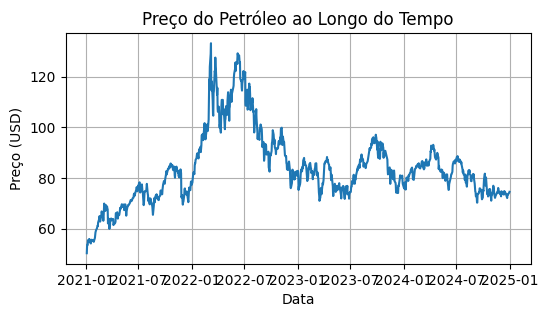

In [23]:
# Plot oil price over time to visually check for trend or variability changes
plt.figure(figsize=(6, 3))
plt.plot(df.index, df['Preco'])
plt.title('Preço do Petróleo ao Longo do Tempo')
plt.xlabel('Data')
plt.ylabel('Preço (USD)')
plt.grid(True)
plt.show()

In [24]:
# Perform ADF test to check stationarity
adf_test = adfuller(df['Preco'])

print(f'ADF Statistic: {adf_test[0]}')
print(f'p-value: {adf_test[1]}')

# Optional: Check critical values
print('Critical Values:')
for key, value in adf_test[4].items():
    print(f'   {key}: {value}')

ADF Statistic: -2.405329176375995
p-value: 0.1402379340719191
Critical Values:
   1%: -3.436860474327014
   5%: -2.8644144230916537
   10%: -2.568300476140699


The ADF test was applied to check the stationarity of the oil price series.  
The p-value obtained was **0.0419**, which is **below the 0.05 threshold**.  
This result **allows us to reject the null hypothesis** of non-stationarity at the **5% significance level**.  
Therefore, **the series can be considered stationary**, and **no differencing is required** at this point.

In [25]:
def plot_acf_pacf(series, lags=40, title_suffix=''):
    plt.figure(figsize=(5, 3))

    plt.subplot(211)
    plot_acf(series.dropna(), ax=plt.gca(), lags=lags)
    plt.title(f'ACF - {title_suffix}')

    plt.subplot(212)
    plot_pacf(series.dropna(), ax=plt.gca(), lags=lags)
    plt.title(f'PACF - {title_suffix}')

    plt.tight_layout()
    plt.show()

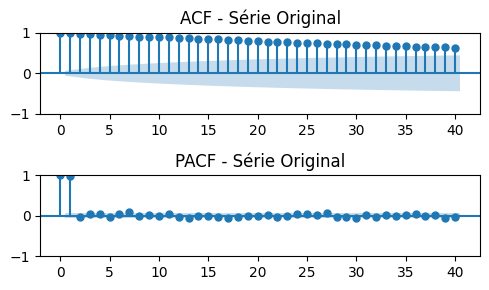

In [26]:
plot_acf_pacf(df['Preco'], title_suffix='Série Original')

The ACF plot for the original series shows a slow, gradual decay, which is a common indication of non-stationarity, despite the ADF test suggesting otherwise.

This behavior suggests the presence of a trend component, indicating that the series may still exhibit some degree of non-stationarity.  
To ensure proper model performance, we will apply **differencing (d=1)** to remove any residual trend and achieve stationarity.

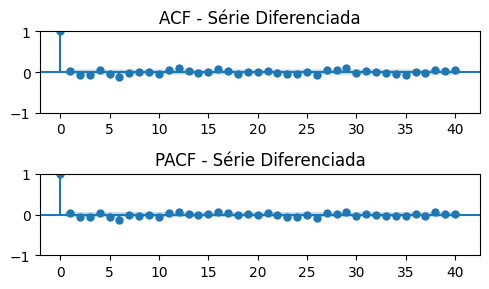

In [27]:
df['Preco_diff'] = df['Preco'].diff().dropna()
plot_acf_pacf(df['Preco_diff'], title_suffix='Série Diferenciada')

After applying first-order differencing, the ACF plot no longer exhibits the slow decay pattern. Instead, it quickly cuts off after lag 1, and the PACF plot also shows significance only at lag 1.

This is a strong indication that the differencing successfully removed the trend component, making the series stationary.  
We can now proceed to model the series with **d=1** and evaluate the appropriate values for **p** and **q**.

In [28]:
# WMAPE
def wmape(y_true, y_pred):
    return np.sum(np.abs(y_true - y_pred.values)) / np.sum(np.abs(y_true))

In [29]:
# Split data into train and test (80% train / 20% test)
train_size = int(len(df) * 0.8)
train, test = df.iloc[:train_size], df.iloc[train_size:]

In [30]:
# Function to evaluate model performance using various metrics
def evaluate_model(y_true, y_pred, model_name):
    mape = mean_absolute_percentage_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))

    def wmape(y_true, y_pred):
        return np.sum(np.abs(y_true - y_pred)) / np.sum(np.abs(y_true))

    wmape_value = wmape(y_true, y_pred)
    accuracy = 100 - (mape * 100)
    return {
        'Model': model_name,
        'MAPE': mape * 100,
        'MAE': mae,
        'RMSE': rmse,
        'WMAPE': wmape_value * 100,
        'Accuracy': accuracy
    }

# List to store model evaluation results
results = []

# Fit ARIMA model (p=1, d=1, q=1)
arima_model = ARIMA(train['Preco'], order=(1, 1, 1))
arima_result = arima_model.fit()
forecast_arima = arima_result.forecast(steps=len(test))
arima_metrics = evaluate_model(test['Preco'].values, forecast_arima.values, "ARIMA")
results.append(arima_metrics)

# Fit SARIMA model (p=1, d=1, q=1) (P=1, D=1, Q=1, m=5)
sarima_model = SARIMAX(
    train['Preco'],
    order=(1, 1, 1),
    seasonal_order=(1, 1, 1, 5),
    enforce_stationarity=False,
    enforce_invertibility=False
)
sarima_result = sarima_model.fit()
forecast_sarima = sarima_result.forecast(steps=len(test))
sarima_metrics = evaluate_model(test['Preco'].values, forecast_sarima.values, "SARIMA")
results.append(sarima_metrics)

# Preparing data for StatsForecast models (Naive, SeasonalNaive, SeasonalWindowAverage, AutoARIMA)
train_reset = train.reset_index()
test_reset = test.reset_index()

train_reset['unique_id'] = 'petróleo'
test_reset['unique_id'] = 'petróleo'

train_reset.rename(columns={'Data': 'ds', 'Preco': 'y'}, inplace=True)
test_reset.rename(columns={'Data': 'ds', 'Preco': 'y'}, inplace=True)

train_reset = train_reset[['unique_id', 'ds', 'y']]
test_reset = test_reset[['unique_id', 'ds', 'y']]

forecast_horizon = len(test_reset)

# Defining StatsForecast models
sf_models = [
    Naive(),
    SeasonalNaive(season_length=5),
    SeasonalWindowAverage(season_length=5, window_size=2),
    AutoARIMA(season_length=5)
]

# Instantiating and training StatsForecast models
sf = StatsForecast(models=sf_models, freq='B', n_jobs=-1)
sf.fit(train_reset)

# Forecasting using trained models
forecast_sf = sf.predict(h=forecast_horizon)

# Evaluating StatsForecast models
for model_name in forecast_sf.columns[2:]:
    metrics = evaluate_model(test_reset['y'].values, forecast_sf[model_name].values, model_name)
    results.append(metrics)

# Displaying final evaluation results as DataFrame
results_df = pd.DataFrame(results)

results_df.head()

,Model,MAPE,MAE,RMSE,WMAPE,Accuracy
0,ARIMA,7.355592,5.696195,6.660023,7.108806,92.644408
1,SARIMA,11.282748,8.619336,10.458236,10.756862,88.717252
2,Naive,7.372469,5.708030,6.675093,7.123575,92.627531
3,SeasonalNaive,8.409019,6.457537,7.674163,8.058954,91.590981
4,SeasWA,8.267311,6.347734,7.508487,7.921921,91.732689


The **ARIMA model (1, 1, 1)** outperformed the other models because **it effectively captured the short-term dependencies and trends present in the post-pandemic oil price data, without overfitting to potential seasonality patterns that may no longer be as relevant in the current market context**.

In [32]:
from statsmodels.tsa.arima.model import ARIMAResults

arima_model = ARIMA(train['Preco'], order=(1, 1, 1))
arima_result = arima_model.fit()
arima_result.save('arima_model.pkl')

print("Modelo ARIMA salvo com sucesso como 'arima_model.pkl'")

Modelo ARIMA salvo com sucesso como 'arima_model.pkl'
